# Análisis de voz en audios de WhatsApp
Se realiza un análisis en audios obtenidos de la aplicación de WhatsApp con el objetivo de identificar la voz del mensaje a través de la red neuronal CNN, alcanzando resultados satisfactorios con una precisión de aproximadamente el 95% medida a través de la variable “Accuracy” en predicciones categóricas.

El proceso empieza con una etapa de obtención de la muestra de audios de 6 personas de repartidas equitativamente en sexo masculino y femenino. 20 audios por persona, 10 para entrenamiento y 10 para test, y una cantidad no controlada en audios para validación. Y el notebook da inicio en la etapa de procesamiento del audioset, en los cálculos sobre 5 métricas de audios espaciales usando la librería “Librossa” para procesamientos de audios.

El uso de las metricas seleccionadas para el analisis no es de mi autoria, es decir, es recomendacion de un paper. Por lo que se hizo uso ciego de las mismas sin descartar ninguna. A fines practicos es mejor probar resultados y luego evaluar su factibilidad de procesamiento en cada una.

# Librerias a Utilizar

Se intentó mantener al inicio todas las importaciones necesarias para poder trabajar en el notebook. Hay bibliotecas que están "comentadas" porque en Google Colab no necesitan instalación previa, sí en entornos locales.

In [2]:
# Desinstalamos este apartado que genera problemas con pyaudio
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 188 kB of archives.
After this operation, 927 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Fetched 188 kB in 1s (195 kB/s)
Selecting previously unselected package libportaudio2:amd64.
(Reading database ... 120903 files and directories currently installed.)
Pre

In [3]:
!pip install pyaudio               # Para grabar y reproducir audio
!pip install librosa               # Para análisis de audio y música
!pip install SpeechRecognition     # Para reconocimiento de voz
# !pip install numpy                 # Para operaciones numéricas con matrices
# !pip install matplotlib            # Para visualizaciones y gráficos
# !pip install pandas                # Para manipulación y análisis de datos
!pip install scikit-learn          # Para algoritmos de aprendizaje automático y modelado
!pip install tensorflow            # Para aprendizaje profundo y redes neuronales
!pip install scikeras


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyaudio: filename=PyAudio-0.2.14-cp310-cp310-linux_x86_64.whl size=63858 sha256=8e9c414d76424795ae28bc75a9a51fac8f799f4acbebf87ab72a0158e26be195
  Stored in directory: /root/.cache/pip/wheels/d6/21/f4/0b51d41ba79e51b16295cbb096ec49f334792814d545b508c5
Successfully built pyaudio
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 39.0 MB/s eta 0:00:00


In [4]:
# Importaciones estándar de Python
import os
import glob
import io
from datetime import datetime
import time
import random

# Audio y procesamiento de señales
import pyaudio
import librosa
import librosa.display
import speech_recognition as sr

# Visualizaciones
import matplotlib.pyplot as plt

# Análisis y manipulación de datos
import pandas as pd
import numpy as np

# Machine Learning y preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn import metrics

# Deep Learning con Keras y TensorFlow
import sklearn as sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Convolution2D, MaxPooling2D, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras import regularizers


In [5]:
# Evitamos la numeracion cientifica en los datos
np.set_printoptions(suppress=True)

# Preparacion de Datos

Tenemos segmentado con anterioridad los datos para Entrenamiento, Validacion y Test, que para poder trabajarlos se crea un DF guia que tendra como caracteristicas contar con el id del audio, la persona, y la direccion de la carpeta local, para ello primero se debe explorar los directorios y ver que contienen.

In [6]:
import gdown

# URL del archivo zip en Google Drive
url =

# Especifica la ruta de destino para guardar el archivo zip
output = '/content/Audio.zip'

# Descarga el archivo zip desde Google Drive
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=12RNpFzuW7llBw4s_BmQ9YVE2KxXxksdH
To: /content/Audio.zip
100%|██████████| 134M/134M [00:01<00:00, 78.9MB/s]


'/content/Audio.zip'

In [7]:
# Descomprimir dataset
!unzip -qq Audio.zip

In [8]:
# Funcion que sirve para recorrer directorios de carpeta
def explora_dir(directory_name):
    '''
    Acepta el nombre de directorio como argumento e imprime el contenido de cada directorio secuencialmente.
    Imprime los subdirectorios y el número de imágenes presentes en cada uno.
    '''
    for dirpaths, dirnames, filenames in os.walk(directory_name):
        print(f"Existen {len(dirnames)} directorios y {len(filenames)} audios en '{dirpaths}'")

In [9]:
# Carpeta de Entrenamiento
dir_Train='/content/Train'
explora_dir(dir_Train)

Existen 6 directorios y 0 audios en '/content/Train'
Existen 0 directorios y 10 audios en '/content/Train/Cel'
Existen 0 directorios y 10 audios en '/content/Train/Bel'
Existen 0 directorios y 10 audios en '/content/Train/Elias'
Existen 0 directorios y 10 audios en '/content/Train/Fran'
Existen 0 directorios y 10 audios en '/content/Train/Mica'
Existen 0 directorios y 10 audios en '/content/Train/Ari'


In [10]:
# Carpeta de Test
dir_Test='/content/Test'
explora_dir(dir_Test)

Existen 6 directorios y 0 audios en '/content/Test'
Existen 0 directorios y 10 audios en '/content/Test/Cel'
Existen 0 directorios y 10 audios en '/content/Test/Bel'
Existen 0 directorios y 10 audios en '/content/Test/Elias'
Existen 0 directorios y 10 audios en '/content/Test/Fran'
Existen 0 directorios y 10 audios en '/content/Test/Mica'
Existen 0 directorios y 10 audios en '/content/Test/Ari'


In [11]:
# Carpeta de Validación
dir_Val='/content/Val'
explora_dir(dir_Val)

Existen 6 directorios y 0 audios en '/content/Val'
Existen 0 directorios y 9 audios en '/content/Val/Cel'
Existen 0 directorios y 6 audios en '/content/Val/Bel'
Existen 0 directorios y 10 audios en '/content/Val/Eli'
Existen 0 directorios y 10 audios en '/content/Val/Fran'
Existen 0 directorios y 10 audios en '/content/Val/Mica'
Existen 0 directorios y 10 audios en '/content/Val/Ari'


Creamos 3 dataframe en base a los archivos de las carpetas, esto sera usado para tener una guia de las personas y los archivos a los que se corresponden.

In [12]:
# Función que sirve para crear un df guia

def crear_df_del_directorio(dir_base):
    datos = {'id_audio': [], 'Persona': [], 'file_path': []}

    for root, dirs, files in os.walk(dir_base):
        for file in files:
            id_audio = file
            persona = os.path.basename(root)
            direccion = os.path.join(dir_base, persona, str(id_audio))

            datos['id_audio'].append(id_audio)
            datos['Persona'].append(persona)
            datos['file_path'].append(direccion)
    df = pd.DataFrame(datos)
    return df

In [13]:
# Creamos los dataframe guias
df_train= crear_df_del_directorio(dir_Train)
df_test=  crear_df_del_directorio(dir_Test)
df_val= crear_df_del_directorio(dir_Val)


# Muestra uno de los DataFrame resultante
df_train.head()

,id_audio,Persona,file_path
0,Ce (15).wav,Cel,/content/Train/Cel/Ce (15).wav
1,Ce (9).wav,Cel,/content/Train/Cel/Ce (9).wav
2,Ce (13).wav,Cel,/content/Train/Cel/Ce (13).wav
3,Ce (19).wav,Cel,/content/Train/Cel/Ce (19).wav
4,Ce (7).wav,Cel,/content/Train/Cel/Ce (7).wav


## Verificacion del Audio
Un audio se puede observar, no solo escuchar, por lo que en este caso comprobamos que tenemos audios en los directorios tomando un archivo aleatorio y graficando su longitud de onda.

Class:  Mica


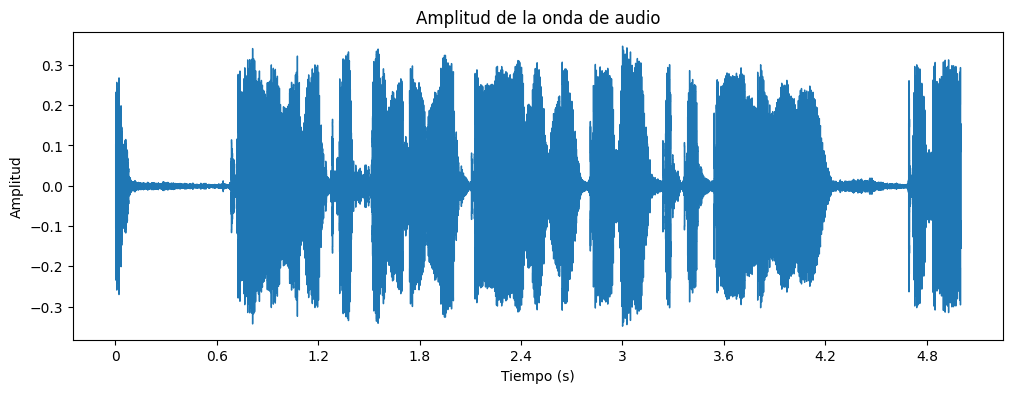

In [14]:
# Captura un indice aleatorio
i = random.choice(df_train.index)

# Selecciono el id de la fila
audio_name = df_train.id_audio[i]
persona=df_train.Persona[i]

# Creo la ruta del audio
path = os.path.join(dir_Train, persona, str(audio_name))

# Persona dueña del audio
print('Class: ', df_train.Persona[i])

# Carga el archivo en un formato serie de tiempo [x] y almacena el sample rate en [sr]
x, sr = librosa.load(path)

# Imprime la serie de tiempo en un grafico de amplitud de onda
plt.figure(figsize=(12, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Amplitud de la onda de audio')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

## Calculo de Metricas Principales de Audios
Esta parte es particularmente compleja, no en codigo, si no en comprension. Los audios son caracterizados por muchas variables espaciales. Que quizas un ingeniero en sonidos las conozca a la perfeccion, en nuestro caso, obtenemos todas las conocidas sin descriminar ninguna.
Y por siguiente mostramos cuales son estas variables, para entender su espacialidad.

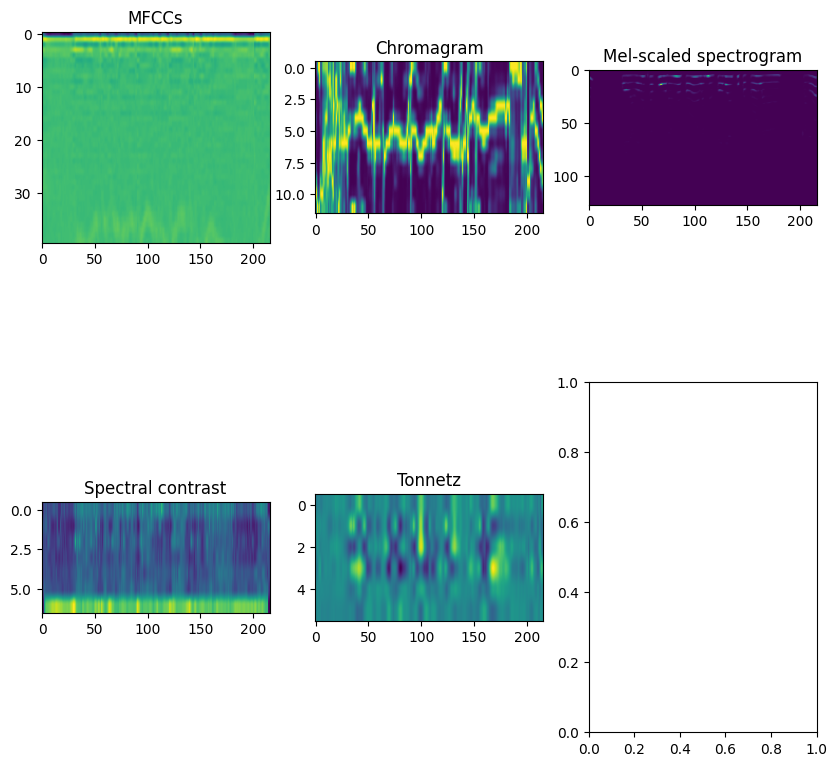

In [15]:
# Todas las metricas las graficamos para el audio aleatorio capturado en el paso anterior

mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40)
chromagram = librosa.feature.chroma_stft(y=x, sr=sr)
mel_spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128)
spectral_contrast = librosa.feature.spectral_contrast(y=x, sr=sr)
tonnetz = librosa.feature.tonnetz(y=x, sr=sr)


fig, axs = plt.subplots(2, 3, figsize=(10, 10))

# MFCCs
axs[0, 0].imshow(mfccs, aspect=5)
axs[0, 0].set_title('MFCCs')

# Chromagram
axs[0, 1].imshow(chromagram, aspect=12)
axs[0, 1].set_title('Chromagram')

# Mel-scaled spectrogram
axs[0, 2].imshow(mel_spectrogram)
axs[0, 2].set_title('Mel-scaled spectrogram')

# Spectral contrast
axs[1, 0].imshow(spectral_contrast, aspect=15)
axs[1, 0].set_title('Spectral contrast')

# Tonnetz
axs[1, 1].imshow(tonnetz, aspect=20)
axs[1, 1].set_title('Tonnetz')

# Show
plt.show()

Desde este punto ya procesamos estas metricas por cada audio que tengamos, para luego poder ingresarlas a la red neuronal

In [16]:
# Creamos una funcion para extraer las mediciones del audio. Devuelve un array de las metricas por cada fila del dataframe

def extract_features(files):

    # Establece el nombre de la ruta a donde están los archivos de audio en mi computadora
    persona=files.Persona
    audio_name=files.id_audio
    file_name = files.file_path

    # Carga el archivo de audio como una serie de tiempo de coma flotante y asigna la frecuencia de muestreo predeterminada
    # Sample rate is set to 22050 by default
    # la serie de tiempo esta almacenada en [X]
    X, sample_rate = librosa.load(file_name)

    # genera Mel-frequency cepstral coefficients (MFCCs) de la serie de tiempo
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Genera una transformada de Fourier a corto plazo (STFT) para usar en chroma_stft

    stft = np.abs(librosa.stft(X))

    # Calcula un cromagrama a partir de una forma de onda o espectrograma de potencia.

    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Calcula un espectograma de mel-scaled

    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)

    # Calcula el contraste espectral

    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Calcula las características del centroide tonal (tonnetz)

    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),sr=sample_rate).T,axis=0)

    # Pedimos que nos devuelva todos los indicadores mas el target
    return mfccs, chroma, mel, contrast, tonnetz

Aplicamos la funcion a cada fila de nuestro dataframe guia, de esta forma nos devolvera una biblioteca que contendra 6 arrays por fila (audio)

In [17]:
# Obtenemos las caracteristicas de cada audio y medimos el tiempo de demora de la consulta

startTime = time.time()

features_train = df_train.apply(extract_features, axis=1)
features_test = df_test.apply(extract_features, axis=1)

finishTime = time.time()

In [18]:
print('Para procesar ', df_train.shape[0], 'audios llevo un \n'
    'tiempo de Consulta de ',finishTime-startTime, ' seg')

Para procesar  60 audios llevo un 
tiempo de Consulta de  83.61018514633179  seg


In [19]:
# Observamos las features, tendremos 5 columnas con array
features_train.head()

0    ([-342.28918, 128.21375, -22.021168, 30.596342...
1    ([-288.60052, 182.50496, -27.97035, 59.947086,...
2    ([-335.8174, 123.750145, -27.62335, 20.708822,...
3    ([-289.8694, 168.0167, 4.6371684, 52.26955, 9....
4    ([-265.41092, 177.60487, -25.576986, 54.0645, ...
dtype: object

In [20]:
# Concatenamos las 5 columnas lo que nos devolvera una matriz con las metricas de cada audio, en este punto ya tenemos hecho lo mas complejo
X_train = []

for i in range(0, len(df_train)):

    X_train.append(np.concatenate((features_train[i][0], features_train[i][1],

                features_train[i][2], features_train[i][3],

                features_train[i][4]), axis=0))

X_test = []

for i in range(0, len(df_test)):

    X_test.append(np.concatenate((features_test[i][0], features_test[i][1],

                features_test[i][2], features_test[i][3],

                features_test[i][4]), axis=0))

## Normalización de datos

In [21]:
# Cantidad de categorias a predecir, esta variable la ocuparemos seguidos por lo que la definimos aca arriba
Categorias=len(df_train.Persona.unique())

Para evitar complicacions futuras con los formatos, se le indico a todas las variables X e y que son array. En esta parte del codigo definimos las de entrenamiento y test, aprovechando que entre los features y los dataframe tienen el mismo orden en filas. Asumiendo que no se cruzaran los datos

In [22]:
y_train=np.array(df_train['Persona'])
y_test=np.array(df_test['Persona'])

# Transformamos las etiquetas a variables numericas y luego le damos formato categorico
y=np.array(df_train.Persona.unique()) # Categorias para entrenar el LabelEncoder
lb = LabelEncoder()
lb.fit(y)

y_train = to_categorical(lb.transform(y_train),Categorias)
y_test = to_categorical(lb.transform(y_test),Categorias)

# Se deben convertir las variables en Numpy Array para ingregar al modelo de CNN
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Normalizamos la variable X usando la funcion normalize de sklearn
X_train = normalize(X_train, norm='l2')
X_test = normalize(X_test, norm='l2')

# Modelo de Red Neuronal
Como las metricas de audio son datos espaciales se opto por trabajar con Red Neuronal CNN, que es recomendada para empezar en este tipo de analisis.

## Construccion del modelo
No hay mucho por comentar aca, se probaron varias alternativas y parece que la sencilla siempre es la mas funcional.

In [23]:
neuronas=len(X_train[0])

print('La cantidad de neuronas a elegir sera igual al tamaño del array de la variable metrica, que es un conjunto de indicadores claves de audio: \n', neuronas)


La cantidad de neuronas a elegir sera igual al tamaño del array de la variable metrica, que es un conjunto de indicadores claves de audio: 
 193


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

# Crear un modelo secuencial
model = Sequential()

# Etapa 1: Capa de entrada con 193 neuronas y activación 'relu'
model.add(Dense(neuronas, input_shape=(193,), activation='relu'))

# Etapa 2: Aplicar Dropout para prevenir sobreajuste
model.add(Dropout(0.1))

# Etapa 3: Capa oculta con 128 neuronas y activación 'relu'
model.add(Dense(128, activation='relu'))

# Etapa 4: Aplicar Dropout nuevamente
model.add(Dropout(0.25))

# Etapa 5: Otra capa oculta con 128 neuronas y activación 'relu'
model.add(Dense(128, activation='relu'))

# Etapa 6: Aplicar Dropout de manera más agresiva
model.add(Dropout(0.5))

# Etapa 7: Capa de salida con 4 neuronas (categorías) y activación 'softmax'
model.add(Dense(Categorias, activation='softmax'))  # Número de categorías a predecir

# Compilar el modelo con función de pérdida 'categorical_crossentropy', y el optimizador "adam" es la vieja confiable
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 193)               37442     
                                                                 
 dropout (Dropout)           (None, 193)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               24832     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 7

## Funciones

Funciones implementadas para evitar el sobre ajuste al momento de entrenar, esto es importante modificar segun los datos de entrenamiento. La primera vez recomiendo no usarlas o pueden no obtener los resultados esperados.

### Guardado de pesos

In [25]:
# Función para configurar el guardado de los pesos a medida que se va entrenando, muy útil cuando el procesamiento es largo y se puede perder por desconexión
def create_model_check_point_callback(checkpoint_path, monitor='val_loss'):
    """
    Toma el camino donde guardar los mejores pesos modelo obtenidos durante el entrenamiento.
    """
    # Crea un callback para guardar los pesos del modelo durante el entrenamiento
    model_checkpoint_cb = tf.keras.Callbacks.ModelCheckpoint(
        monitor=monitor,  # Elige la métrica a monitorear (por defecto, la pérdida en el conjunto de validación)
        filepath=checkpoint_path,  # Ruta donde se guardarán los pesos del modelo
        save_best_only=True,  # Guarda solo los pesos del modelo si la métrica monitorizada mejora
        save_weights_only=True,  # Guarda solo los pesos del modelo en lugar del modelo completo
        save_freq='epoch',  # Guarda los pesos al final de cada época
        verbose=1  # Muestra mensajes detallados durante el proceso de guardado
    )
    return model_checkpoint_cb  # Devuelve el callback configurado

### Parada automatica

In [26]:
# Criterio de parada extra, épocas que espera sin mejorar para detener entrenamiento
''' from tensorflow.keras.callbacks import EarlyStopping '''

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')

# Crea un objeto ReduceLROnPlateau, un callback que ajusta la tasa de aprendizaje durante el entrenamiento si la mejora en la métrica se estanca.
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',  # Métrica a monitorear, en este caso, la pérdida en el conjunto de validación.
    patience=5,  # Número de épocas sin mejora después del cual la tasa de aprendizaje se reducirá.
    verbose=1  # Muestra mensajes detallados durante el proceso de ajuste de la tasa de aprendizaje.
)

## Entrenamiento

In [27]:
# Entrenamiento del modelo con el conjunto de datos de entrenamiento (X_train).
# Se especifica el número de épocas (epochs) como 50, tamaño del lote (batch_size) como 300,
# conjunto de datos de validación (test_data) para evaluar el rendimiento en datos no vistos durante el entrenamiento.
# Se utiliza la lista de callbacks [earlystop, learning_rate_reduction, ModelCheckPoint_model_cb]
# para aplicar acciones específicas durante el entrenamiento (por ejemplo, detener el entrenamiento temprano, ajustar la tasa de aprendizaje, guardar los mejores pesos).
history = model.fit(X_train,
                    y_train,
                    batch_size=256,
                    epochs=300,
                    validation_data=(X_test, y_test),
                    callbacks=[earlystop, learning_rate_reduction] # En este punto pueden quitar las funciones en su primera corrida para evitar interrupciones equivocadas
                    )

Epoch 1/300
1/1 [==============================] - 2s 2s/step - loss: 1.7996 - accuracy: 0.1500 - val_loss: 1.7902 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 2/300
1/1 [==============================] - 0s 59ms/step - loss: 1.7832 - accuracy: 0.2167 - val_loss: 1.7891 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 3/300
1/1 [==============================] - 0s 70ms/step - loss: 1.7902 - accuracy: 0.2500 - val_loss: 1.7878 - val_accuracy: 0.2667 - lr: 0.0010
Epoch 4/300
1/1 [==============================] - 0s 69ms/step - loss: 1.7802 - accuracy: 0.1000 - val_loss: 1.7866 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 5/300
1/1 [==============================] - 0s 77ms/step - loss: 1.7936 - accuracy: 0.2167 - val_loss: 1.7853 - val_accuracy: 0.3000 - lr: 0.0010
Epoch 6/300
1/1 [==============================] - 0s 55ms/step - loss: 1.7913 - accuracy: 0.2000 - val_loss: 1.7840 - val_accuracy: 0.2833 - lr: 0.0010
Epoch 7/300
1/1 [==============================] - 0s 69ms/step - loss: 1.7916 - acc

In [28]:
# Esta funcion sirve para graficar 2 curvas que muestren como evolucionan 2 metricas
def plot_curves(history):
    '''
    Devuelve curvas de loss u accuracy, separadas para métricas de entrenamiento y validación.
    '''
    train_loss=history.history['loss']
    val_loss=history.history['val_loss']

    train_accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(1,len(history.history['loss'])+1)
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss")
    plt.plot(epochs,val_loss,label="validation_loss")
    plt.title("Pérdida en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc")
    plt.plot(epochs,val_accuracy,label="validation_acc")
    plt.title("Precisión en el Entrenamiento")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

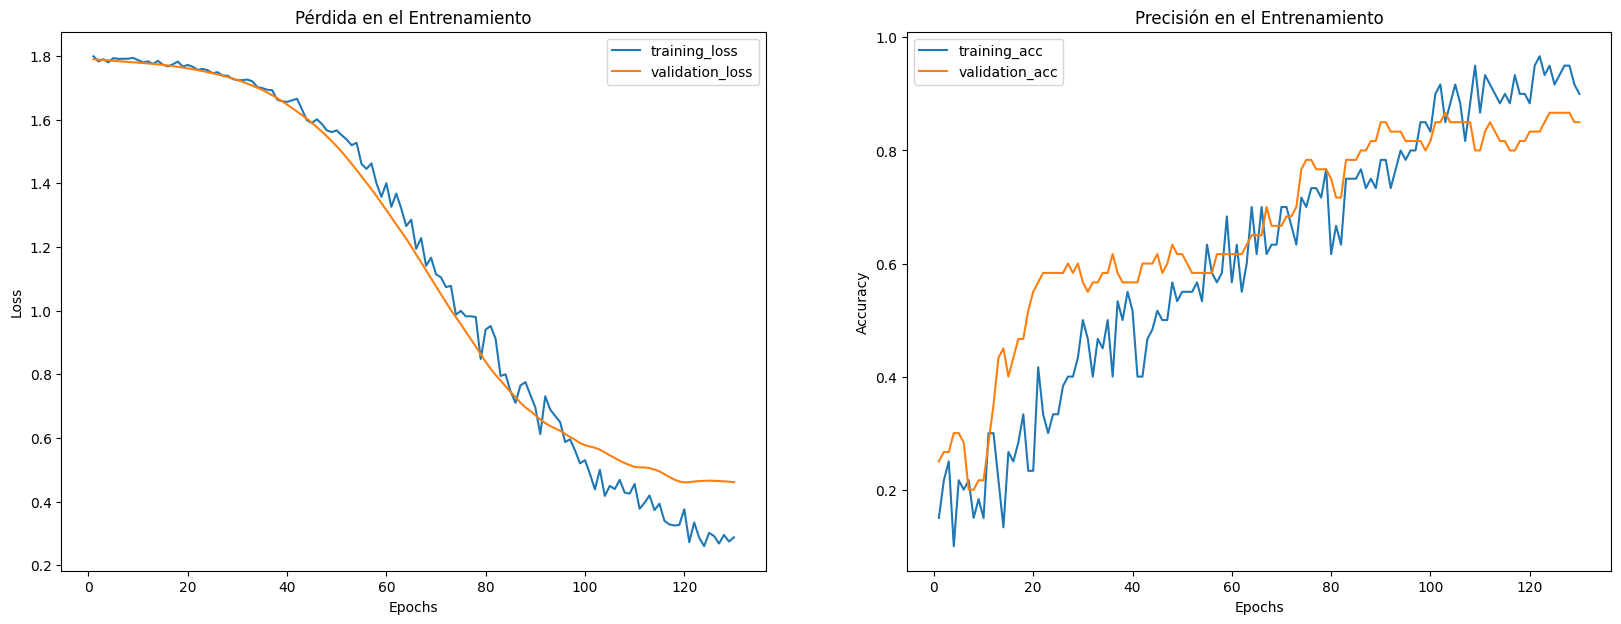

In [29]:
plot_curves(history)

El modelo corta antes del overfitting, por lo que estamos en la situacion ideal. A su vez que se estan obteniendo acurracys muy elevados.

# Observacion de las predicciones

In [30]:
def predict_class(y_pred):
    y_class = []
    for i in y_pred:
        y_class.append(int(np.where(i == np.amax(i))[0]))

    return np.array(y_class)

In [31]:
# Obtenemos nuestras predicciones de los datos de prueba

pred = model.predict(X_test)

pred_class = predict_class(pred)
real_class = lb.transform(np.array(df_test['Persona']))

pred_name = lb.inverse_transform(pred_class)
real_name=df_test['Persona']



2/2 [==============================] - 0s 6ms/step


In [32]:
# Se crea un dataframe con información relacionada a las predicciones
pred_df=pd.DataFrame({
    'Path': df_test.id_audio,
    'y_true':real_class,
    'y_pred':pred_class,
    'pred_conf':pred.max(axis=1),
    'actual_class_name':real_name,
    'pred_class_name':pred_name
     })
pred_df.sample(10)

,Path,y_true,y_pred,pred_conf,actual_class_name,pred_class_name
34,Fr (28).wav,4,4,0.734600,Fran,Fran
58,ar (9).wav,0,0,0.529919,Ari,Ari
39,Fr (16).wav,4,0,0.760656,Fran,Ari
43,Mi (24).wav,5,5,0.836252,Mica,Mica
32,Fr (9).wav,4,4,0.813639,Fran,Fran
42,Mi (37).wav,5,5,0.990566,Mica,Mica
19,Be (24).wav,1,1,0.816217,Bel,Bel
17,Be (25).wav,1,1,0.884170,Bel,Bel
45,Mi (12).wav,5,5,0.971906,Mica,Mica
2,Ce (21).wav,2,2,0.960326,Cel,Cel


In [33]:
# Función para graficar como imagen la matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_preds, labels=None, model_name=None, normalize=None):
    """
    Función para graficar la Matrix de confusión
    y_true: vector de salida real
    y_predic: vector de salida predicho por el modelo
    labels: opcional, para nombrar las clases. Lista con strings
    model_name: opcional, para poner un título al gráfico
    normalize: {'true', 'pred', 'all'}, default=None
        Normalizes confusion matrix over the true (rows), predicted (columns)
        conditions or all the population. If None, confusion matrix will not be
        normalized.
    """
    if normalize:
        cm = confusion_matrix(y_true, y_preds, normalize=normalize)
    else:
        cm = confusion_matrix(y_true, y_preds)
    cmd = ConfusionMatrixDisplay(cm, display_labels=labels)
    cmd.plot()
    cmd.ax_.set(xlabel='Clase Predicha', ylabel='Clase Real')
    if model_name:
        cmd.ax_.set(title=model_name)

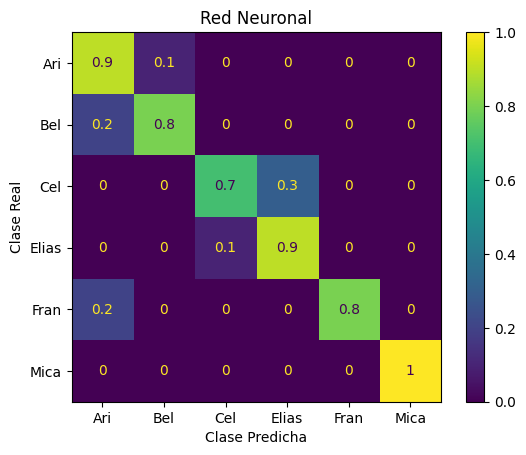

In [34]:
plot_confusion_matrix(pred_df['y_true'], pred_df['y_pred'],labels=lb.inverse_transform([0,1,2,3,4,5]), model_name="Red Neuronal", normalize='true')

Los audios no tienen 1 solo procesamiento ni de ruido, ni de escucha, hay fragmentos que posiblemente no sean audibles o contengan menos de 1 segundo de voz. Esto es fue asi aproposito para agregar algo de robustes al modelo.

# Test
Aca se encuentran un preprosecamiento de datos, sobre audios desconocidos para el modelo, asi poder devuelta analizar su precision y evaluar a su vez el tiempo de respuesta.

In [35]:
df_val.head()

,id_audio,Persona,file_path
0,Ce (24).wav,Cel,/content/Val/Cel/Ce (24).wav
1,Ce (16).wav,Cel,/content/Val/Cel/Ce (16).wav
2,Ce (28).wav,Cel,/content/Val/Cel/Ce (28).wav
3,Ce (20).wav,Cel,/content/Val/Cel/Ce (20).wav
4,Ce (4).wav,Cel,/content/Val/Cel/Ce (4).wav


In [36]:
# Captura un indice aleatorio
i = random.choice(df_val.index)

file_val=df_val.loc[i]
file_val

id_audio                      Be (8).wav
Persona                              Bel
file_path    /content/Val/Bel/Be (8).wav
Name: 12, dtype: object

In [37]:
# Calculamos las features y los tiempos de preparacion
ti=time.time()

features_val = extract_features(file_val)

X_val=[]

X_val.append(np.concatenate((features_val[0], features_val[1],

                    features_val[2], features_val[3],

                    features_val[4]), axis=0))

X_val = np.array(X_val)
X_val = normalize(X_val,norm='l2')


tm=time.time()
dif1=tm-ti
print('Tiempo de prepacion del audio: ', dif1)

# Obtenemos nuestras predicciones de los datos de prueba

pred = model.predict(X_val)

pred_class = predict_class(pred)
pred_name = lb.inverse_transform(pred_class)

tf=time.time()

print("\n La certeza con la que predice el resultado es de: ", pred.max())
print("\n La  prediccion del audio corresponde a: ", pred_name, 'Y la persona real es:', file_val.Persona)
print("\n Tiempo en total que le toma desde preparar el audio hasta realizar la prediccion: ", tf-ti, " seg")

Tiempo de prepacion del audio:  0.5874271392822266
1/1 [==============================] - 0s 27ms/step

 La certeza con la que predice el resultado es de:  0.62367964

 La  prediccion del audio corresponde a:  ['Bel'] Y la persona real es: Bel

 Tiempo en total que le toma desde preparar el audio hasta realizar la prediccion:  0.6923229694366455  seg
